In [1]:
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import math
import networkx as nx
# from haversine import haversine
# import ipfn
# import networkx
import matplotlib.pyplot as plt
from matplotlib import patheffects
%matplotlib inline  
import skmob
from skmob.measures.evaluation import r_squared,rmse, pearson_correlation,common_part_of_commuters,max_error,common_part_of_commuters_distance
# import shapefile as shp

### Importing data, creating tesselation, flow dataframes and radiation model

In [2]:
## Nodes
nodes = pd.read_csv('THE_NODES.txt',sep =" ",  header = None)
nodes = nodes.rename(columns = {0:'county_ID', 1:'population',2: 'latitude', 3: 'longitude', 4: 'intra_county_trips'} )
## Tesselation
nodes_gdf = gpd.GeoDataFrame(nodes,geometry=gpd.points_from_xy(nodes.longitude,nodes.latitude))
tessellation  = nodes_gdf[['county_ID','population','geometry']]
## Edges
links = pd.read_csv('THE_LINKS.txt',sep =" ",  header = None)
links = links.rename(columns = {0:'origin_county', 1:'destination_county',2: 'distance_[km]', 3: 'number_of_trips.'} )
## renaming columns of data
link_ = pd.read_csv('THE_LINKS.txt',sep =" ",  header = None)
link_ = link_.rename(columns = {0:'origin', 1:'destination',2: 'distance_[km]', 3: 'flow'} )
link_ = link_[['origin','destination','flow']]



In [3]:
# unique_tile_ids  = list(np.unique(links['origin']))
# unique_tile_ids.extend(list(np.unique(links['destination'])))
# unique_tile_ids = list(np.unique(unique_tile_ids))
# unique_tile_ids = [str(x) for x in unique_tile_ids]

In [4]:
fdf = skmob.FlowDataFrame(
    data = links, origin = 'origin_county' , destination = 'destination_county', flow = 'number_of_trips.' ,
    tessellation=tessellation, tile_id='county_ID');

C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\scikit_mobility-1.0-py3.7.egg\skmob\core\flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).


In [5]:
## Radiation model
from skmob.utils import utils, constants
from skmob.models import Gravity
from skmob.models import Radiation
## create tot_outflows
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)['flow'].sum().fillna(0).values
## insert outflow of zero to missing index:  545  with id value:  15005
tot_outflows = np.insert(tot_outflows, 545,0)
## add tot outflows column to tesselation
tessellation[constants.TOT_OUTFLOW] = tot_outflows



C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [6]:
## generate radiation model
radiation = Radiation()
## create instance of radiation model
rad_flows = radiation.generate(tessellation, tile_id_column='county_ID', tot_outflows_column='tot_outflow',
                                   relevance_column='population', out_format='flows_sample')


100%|██████████████████████████████████████████████████████████████████████████████| 3141/3141 [02:50<00:00, 18.46it/s]
C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\scikit_mobility-1.0-py3.7.egg\skmob\core\flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).


In [7]:
## Comparing empirical flows against model
xy_radiation = fdf.merge(rad_flows, on=['origin', 'destination'])


In [8]:
xy_radiation

,origin,destination,distance_[km],flow_x,flow_y
0,1001,1007,76.861597,7,54
1,1001,1013,87.918287,37,25
2,1001,1015,152.858742,5,12
3,1001,1021,38.103967,350,258
4,1001,1031,140.051395,8,7
...,...,...,...,...,...
82200,56045,56021,298.842613,2,28
82201,56045,56025,186.412115,7,138
82202,56045,56027,94.651664,11,50
82203,56045,56031,190.363529,8,16


In [9]:
def makeNetworkFromFiles(fedges,nodes,flow_i):
    ''' Generate a network from csv files.
    The first column of the nodes file is taken to be the id by default.
    The nodes file must contain columns named weight, source, and target.
    The deli parameter is the delimeter of the file. '''
    G = nx.Graph()  #modified from lecture 12 
    fn=nodes.transpose()
    n_attr=len(fn.index.values)
    attr=fn.index.values
    for n in fn.columns:
        attr_node=dict(list(zip(attr, fn[n].values)))
        
        G.add_node(n,attr_dic=attr_node)
    #fl=pd.read_csv(fedges,delimiter=deli)
    fl = fedges
    fl.columns = list(map(str.lower, fl.columns))
    for L in fl.index.values:
        
        #print(fl['origin'][L])
    #    print((G.nodes[str(fl['origin'][L])]['attr_dic']['latitude']))
        #dist = geopy.distance.geodesic((
           # G.nodes[str(fl['origin'][L])]['attr_dic']['latitude'],G.nodes[str(fl['origin'][L])]['attr_dic']['longitude']),
            #(G.nodes[str(fl['destination'][L])]['attr_dic']['latitude'],
                    #                G.nodes[str(fl['destination'][L])]['attr_dic']['longitude'])).km
 
        
        o_n = fl['origin'][L]
        d_n = fl['destination'][L]
        if o_n != d_n:
            G.add_edge(fl['origin'][L],fl['destination'][L],weight=int(fl[flow_i][L]))
#             dist = geopy.distance.geodesic((G.nodes[o_n]['attr_dic']['latitude'],G.nodes[o_n]['attr_dic']['longitude']), (G.nodes[d_n]['attr_dic']['latitude'],G.nodes[d_n]['attr_dic']['longitude'])).km
#             #print(dist)
            dist = fl['distance_[km]'][L]
            G[o_n][d_n]['distance'] = dist
          
            
    G = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    #GL = max(nx.connected_component_subgraphs(G), key=len) ## no implemented for directed graph
    return G

In [10]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

### Build two undirected weighted graphs with the data and a trip distribution model of your choice (developed in Assignment 2 part 1). The goal is to analyze and compare their network properties.

In [11]:
# import geopy.distance
## Create 
g_actual = makeNetworkFromFiles(xy_radiation,nodes,'flow_x')
g_globally = makeNetworkFromFiles(xy_radiation,nodes,'flow_y')
#g= makeNetworkFromFiles('SchoolEdges.csv', 'SchoolNodes.csv',' ')
#g=makeNetworkFromFiles('USCommuting_LINKS.csv', 'USCommuting_NODES.csv',' ')

degrees_actual=remove_values_from_list(list(dict(g_actual.degree()).values()),0)
degrees_globally=remove_values_from_list(list(dict(g_globally.degree()).values()),0)


w_degrees_actual=remove_values_from_list(list(dict(g_actual.degree(weight  = 'weight')).values()),0)
w_degrees_globally=remove_values_from_list(list(dict(g_globally.degree(weight  = 'weight')).values()),0)

Text(0, 0.5, '$P(k)$')

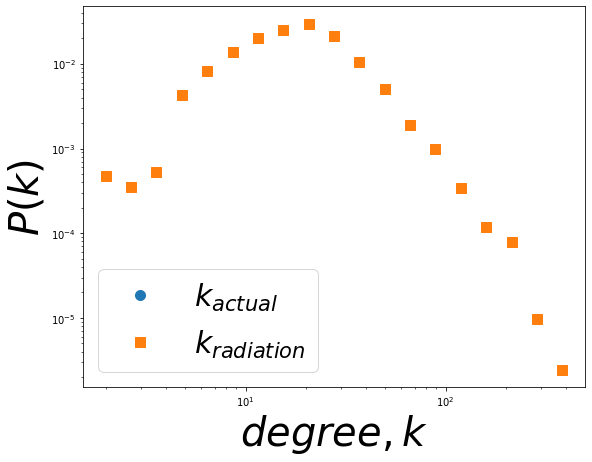

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches((9, 7))

n_bins = 20

#n, bins = np.histogram(out_d, bins = range(min(out_d), max(out_d)+1, 2), normed="True") 
out_logBins = np.logspace(np.log10(min(degrees_actual)), np.log10(max(degrees_actual)),num=n_bins)
out_logBinDensity, out_binedges = np.histogram(degrees_actual, bins=out_logBins, density=True)

#n, bins = np.histogram(in_d, bins = range(min(in_d), max(in_d)+1, 2), normed="True") 
in_logBins = np.logspace(np.log10(min(degrees_globally)), np.log10(max(degrees_globally)),num=n_bins)
in_logBinDensity, in_binedges = np.histogram(degrees_globally, bins=in_logBins, density=True)

ax.loglog(out_logBins[:-1],out_logBinDensity,'o', markersize=10,label=r'$k_{actual}$')
ax.loglog(in_logBins[:-1],in_logBinDensity,'s', markersize=10,label=r'$k_{radiation}$')
ax.legend(fontsize=30)


ax.set_xlabel('$degree, k$',fontsize=40)
ax.set_ylabel('$P(k)$',fontsize=40) 
#plt.savefig("distributions.eps",dpi=200,bbox_inches='tight');

### For both data and model, calculate the degree distributions of degree strengths or weighted degree (similar to Figure 5B below, extracted from the paper: the structure of interurban traffic: a weighted network analysis presented in Lecture 7) (10pts)

Text(0, 0.5, '$P(s)$')

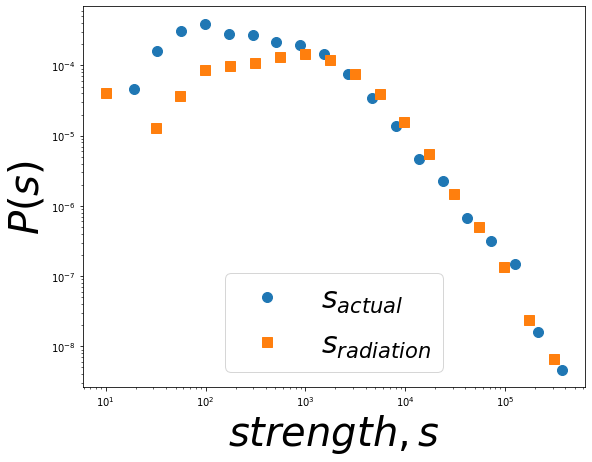

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches((9, 7))

n_bins = 20

#n, bins = np.histogram(out_d, bins = range(min(out_d), max(out_d)+1, 2), normed="True") 
out_logBins = np.logspace(np.log10(min(w_degrees_actual)), np.log10(max(w_degrees_actual)),num=n_bins)
out_logBinDensity, out_binedges = np.histogram(w_degrees_actual, bins=out_logBins, density=True)

#n, bins = np.histogram(in_d, bins = range(min(in_d), max(in_d)+1, 2), normed="True") 
in_logBins = np.logspace(np.log10(min(w_degrees_globally)), np.log10(max(w_degrees_globally)),num=n_bins)
in_logBinDensity, in_binedges = np.histogram(w_degrees_globally, bins=in_logBins, density=True)

ax.loglog(out_logBins[:-1],out_logBinDensity,'o', markersize=10,label=r'$s_{actual}$')
ax.loglog(in_logBins[:-1],in_logBinDensity,'s', markersize=10,label=r'$s_{radiation}$')
ax.legend(fontsize=30)


ax.set_xlabel('$strength, s$',fontsize=40)
ax.set_ylabel('$P(s)$',fontsize=40) 
#plt.savefig("distributions.eps",dpi=200,bbox_inches='tight')

### 2. Compare values of the two networks respect to: maximum degree Kmax, average degree , standard deviation of the average degree, sk, the average clustering coefficient and average shortest path (30 pts)


In [31]:
print('')
print('-------------- Actual Network -------------------')
print("The Maximum Degree for the Networks is ",max(degrees_actual))
print("The Minimum Degree for the Networks is ",min(degrees_actual))
print("The Average Degree for the Networks is ", np.mean(degrees_actual))
print("The STD of the Degrees for the Networks is ",np.std(degrees_actual))

print('')
print('-------------- Radiation Model Network -------------------')
print("The Maximum Degree for the Networks is ",max(degrees_globally))
print("The Minimum Degree for the Networks is ",min(degrees_globally))
print("The Average Degree for the Networks is ", np.mean(degrees_globally))
print("The STD of the Degrees for the Networks is ",np.std(degrees_globally))


print('')
print('-------------- Weighted Actual Network -------------------')
print("The Maximum Weighted Degree for the Actual Network is ",max(w_degrees_actual))
print("The Minimum Weighted Degree for the Actual Network is ",min(w_degrees_actual))
print("The Average Weighted Degree for the Actual Network is ", np.mean(w_degrees_actual))
print("The STD of the Weighted Degrees for the Actual Network is ",np.std(w_degrees_actual))
print('Clustering coefficient: ', nx.average_clustering(g_actual))
# print('Average Shortest path: ',nx.average_shortest_path_length(g_actual))

print('')
print('-------------- Weighted Radiation Constrained Network -------------------')
print("The Maximum Weighted Degree for the Globally Constrained Network is ",max(w_degrees_globally))
print("The Minimum Weighted Degree for the Globally Constrained Network is ",min(w_degrees_globally))
print("The Average Weighted Degree for the Globally Constrained Network is ", np.mean(w_degrees_globally))
print("The STD of the Weighted Degrees for the Globally Constrained Network is ",np.std(w_degrees_globally))
print('Clustering coefficient: ', nx.average_clustering(g_globally))
# print('Average Shortest path: ',nx.average_shortest_path_length(g_globally))


-------------- Actual Network -------------------
The Maximum Degree for the Networks is  513
The Minimum Degree for the Networks is  2
The Average Degree for the Networks is  37.14103788602356
The STD of the Degrees for the Networks is  33.79522637535336

-------------- Radiation Model Network -------------------
The Maximum Degree for the Networks is  513
The Minimum Degree for the Networks is  2
The Average Degree for the Networks is  37.14103788602356
The STD of the Degrees for the Networks is  33.79522637535336

-------------- Weighted Actual Network -------------------
The Maximum Weighted Degree for the Actual Network is  648262
The Minimum Weighted Degree for the Actual Network is  19
The Average Weighted Degree for the Actual Network is  11001.386182744349
The STD of the Weighted Degrees for the Actual Network is  33641.49144530156
Clustering coefficient:  0.5271650225392531

-------------- Weighted Radiation Constrained Network -------------------
The Maximum Weighted Degree

In [15]:
# print('Average Shortest path: ',nx.average_shortest_path_length(g_actual))
# print('Average Shortest path: ',nx.average_shortest_path_length(g_globally))

In [16]:
distances_all_flat = []
for edg in g_actual.edges:
    distances_all_flat.append(g_actual[edg[0]][edg[1]]['distance'])

C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '$P(d)$')

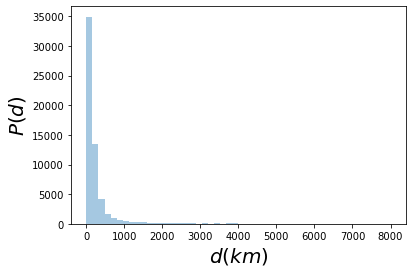

In [17]:
import seaborn as sns
sns.distplot(distances_all_flat,kde = False)
plt.xlabel('$d (km)$',fontsize=20)
plt.ylabel('$P(d)$',fontsize=20)

In [18]:
kk_actual = []
wij_actual = []
dij_actual = []
degrees_actual_dic = g_actual.degree(weight  = 'weight')
for n in g_actual.nodes(data=True):
    for e in g_actual.edges(n[0],data=True):
        kk_actual.append(degrees_actual_dic[e[0]]*degrees_actual_dic[e[1]])
        wij_actual.append(g_actual[e[0]][e[1]]['weight'])
        dij_actual.append(g_actual[e[0]][e[1]]['distance'])

kk_globally = []
wij_globally = []
dij_globally = []
degrees_globally_dic = g_globally.degree(weight  = 'weight')
for n in g_globally.nodes(data=True):
    for e in g_globally.edges(n[0],data=True):
        kk_globally.append(degrees_globally_dic[e[0]]*degrees_globally_dic[e[1]])
        wij_globally.append(g_globally[e[0]][e[1]]['weight'])
        dij_globally.append(g_globally[e[0]][e[1]]['distance'])

Text(0, 0.5, '$<w_{i,j}>$')

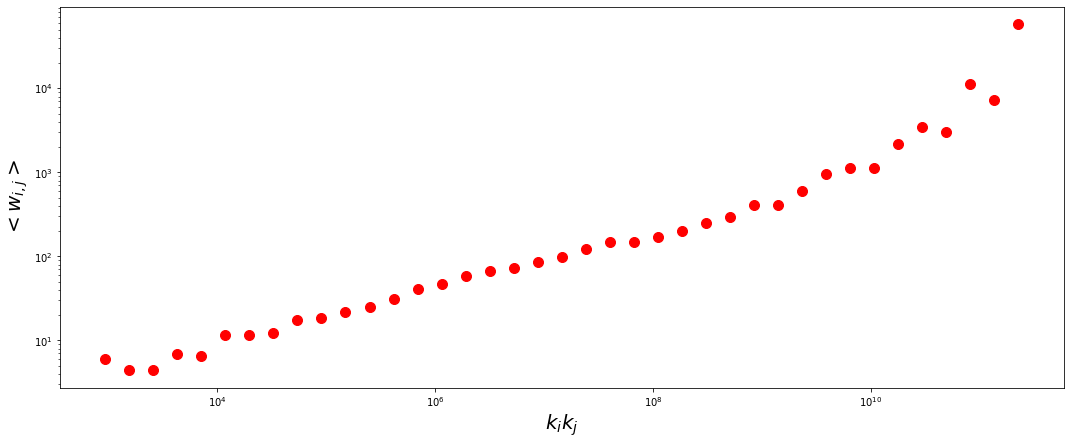

In [19]:
n_bins = 40
kk_logBins = np.logspace(np.log10(min(kk_actual)), np.log10(max(kk_actual)),num=n_bins)
counts, bins = np.histogram(kk_actual, bins=kk_logBins);
sums, bins = np.histogram(kk_actual, bins=kk_logBins,weights=wij_actual);
avg_w = sums/counts;
fig, ax = plt.subplots()
fig.set_size_inches((18, 7))
ax.loglog(bins[:-1],avg_w,linewidth=0,color='r',marker='o',markersize=10)
ax.set_xlabel('$k_ik_j$',fontsize=20)
ax.set_ylabel('$<w_{i,j}>$',fontsize=20)

C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, '$<w_{i,j}>$')

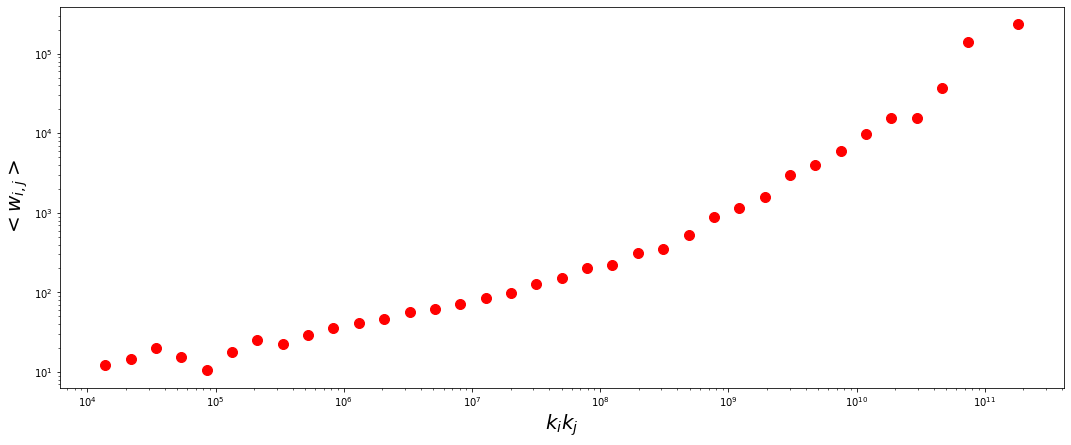

In [20]:
n_bins = 40
kk_logBins = np.logspace(np.log10(min(kk_globally)), np.log10(max(kk_globally)),num=n_bins)
counts, bins = np.histogram(kk_globally, bins=kk_logBins);
sums, bins = np.histogram(kk_globally, bins=kk_logBins,weights=wij_globally);
avg_w = sums/counts;
fig, ax = plt.subplots()
fig.set_size_inches((18, 7))
ax.loglog(bins[:-1],avg_w,linewidth=0,color='r',marker='o',markersize=10)
ax.set_xlabel('$k_ik_j$',fontsize=20)
ax.set_ylabel('$<w_{i,j}>$',fontsize=20)

C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


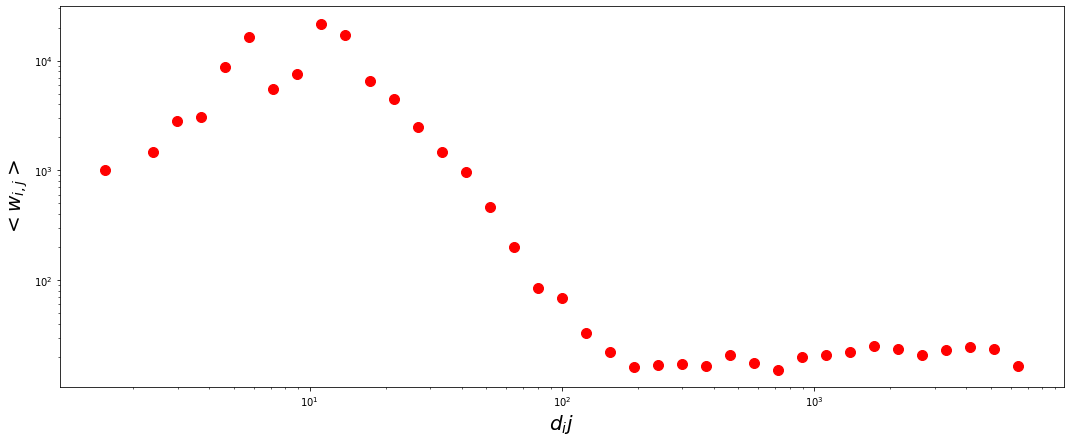

In [21]:
n_bins = 40
kk_logBins = np.logspace(np.log10(min(dij_actual)), np.log10(max(dij_actual)),num=n_bins)
counts, bins = np.histogram(dij_actual, bins=kk_logBins);
sums, bins = np.histogram(dij_actual, bins=kk_logBins,weights=wij_actual);
avg_w = sums/counts;
fig, ax = plt.subplots()
fig.set_size_inches((18, 7))
ax.loglog(bins[:-1],avg_w,linewidth=0,color='r',marker='o',markersize=10)
ax.set_xlabel('$d_ij$',fontsize=20)
ax.set_ylabel('$<w_{i,j}>$',fontsize=20)
plt.savefig("commutes_directed_.eps",dpi=200,bbox_inches='tight')

C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, '$<w_{i,j}>$')

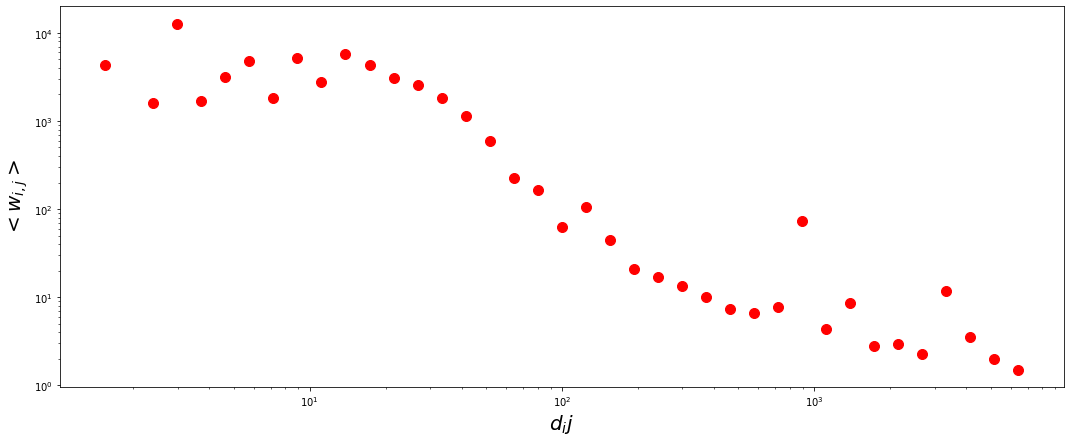

In [22]:
n_bins = 40
kk_logBins = np.logspace(np.log10(min(dij_globally)), np.log10(max(dij_globally)),num=n_bins)
counts, bins = np.histogram(dij_globally, bins=kk_logBins);
sums, bins = np.histogram(dij_globally, bins=kk_logBins,weights=wij_globally);
avg_w = sums/counts;
fig, ax = plt.subplots()
fig.set_size_inches((18, 7))
ax.loglog(bins[:-1],avg_w,linewidth=0,color='r',marker='o',markersize=10)
ax.set_xlabel('$d_ij$',fontsize=20)
ax.set_ylabel('$<w_{i,j}>$',fontsize=20)

### 5. Plot a power law function for the degree distribution: P(k) = C* k-γ  fixing Kmin like in the commuting US network, and selecting γ >1 of your choice that Kmax is close to the data (10pts)

In [25]:
import powerlaw 

In [26]:
## Fit powerlaw
fit=powerlaw.Fit(w_degrees_actual,discrete=True)

Calculating best minimal value for power law fit
C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\powerlaw-1.4.6-py3.7.egg\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mmoud\Anaconda3\envs\skmob\lib\site-packages\powerlaw-1.4.6-py3.7.egg\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide


In [27]:
print ('alpha =',fit.power_law.alpha)   #exponent of the power law
print ('standard error =',fit.power_law.sigma)  #standard error oof the fit
print ('xmin =',fit.xmin) #xmin

alpha = 1.8428699729299418
standard error = 0.02465206628948676
xmin = 4092.0


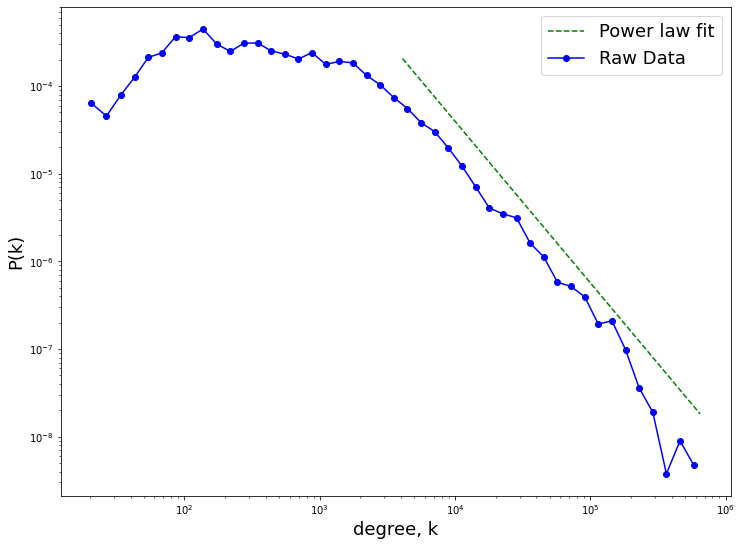

In [28]:
plt.figure(figsize=(12,9))
fit.power_law.plot_pdf(color='g',linestyle='--',label='Power law fit')
powerlaw.plot_pdf(w_degrees_actual,color ='b',marker= 'o',label='Raw Data')
plt.ylabel('P(k)',fontsize=18)
plt.xlabel('degree, k',fontsize=18)
plt.legend(loc='best',fontsize=18)